# **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Assignment 3: n-gram Language Models, Word Sense disambiguation(LSA using SVD), LSTM**

### **Total points: 100**


# Q1. Latent Semantic Analysis (35 Points) 


 - A. Singular Value Decomposition (SVD) based distributed representation of text and documents. You can use python libraries for matrix decomposition (scipy). To demonstrate your work, use the example dataset (Table 2) of "R. A. Harshman (1990). Indexing by latent semantic analysis. Journal of the American society for information science". (10 Points)

 - B. Visualize (2-D) the documents and terms using library of your choice. (10 Points)

 - C. Implement a function that converts a query string to distributed representation and retrieves relevent documents. Visualize the the results as shown in Fig 1 of the paper. (10 Points)

## <CENTER>Task-1 (10 Points)

### Input data

In [1]:
#Dataset
c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'
documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

### Perform preprocessing of documents

In the below cell remove punctuations and keep only words which belong to nltk corpus

In [1]:
import numpy as np
import math
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\54364\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import string
string.punctuation # checking punctuations
def removePunctuation(text):
    return "".join([char for char in text if char not in string.punctuation])#removePunctuation

In [4]:
# TASK CELL
import copy
from nltk.corpus import words
def preprocess(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        preprocessed_message_list: a list of words containing the processed message. 

    '''
    message = message.replace('-',' ')#replace'-' by ' '
    preprocessed_message_list = []
    for  i in word_tokenize(removePunctuation(message)):#lower and clean data
        if i.lower() in words.words():
            preprocessed_message_list.append(i.lower())#fisrt check lower verison of words
        else:
            preprocessed_message_list.append(i)# use original word to check
   

    return preprocessed_message_list

### Verify preprocessed data

In [5]:
for sent in documents:
    print(preprocess(sent))

['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']


##### Expected Output
```CPP
['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']
```

### Assign names to document names
In the below cell create a list of document names. It will be later used to visualize documents

In [6]:
def createDocName(documents):
#      '''
#     Input:
#         documents: list of documents.
#     Output:
#         doc_names: a list of document names. 

#     '''
    a = ['c','m']#set vacob
    doc_names = []#store names
    k = 1
    o = 0
    for i in range(len(documents)):#create doc_names
        temp = []
        temp.append(a[o])
        temp.append(str(k))
        doc_names.append(''.join(temp))
        if k == 5:
            o += 1
            k = 1
            continue
        k += 1
            
    return doc_names
    


In [7]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


##### Expected Output
``` CPP
['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
```

### Words to Index mapping
Retrieve words from documents and create map of word and associate index to it

In [8]:
def build_word_to_ix(documents, stopwords):
#      '''
#     Input:
#         documents: list of documents
#         stopwords: list of stopwords
#     Output:
#         doc_names: map of words and assoicated index. 

#     '''
    word_to_ix_temp = {}#count number of words
    word_list = []#store words
    for message in documents:
        for word in preprocess(message):
            if word not in word_to_ix_temp.keys():
                word_list.append(word)
                word_to_ix_temp[word] = 1
            else:
                word_to_ix_temp[word] += 1
    for token in word_to_ix_temp.keys():#remove freq<1  words
        if word_to_ix_temp[token] < 2:
            word_list.remove(token)
    word_to_ix = {}#store words' index
    for cao in word_list:#clean stopwords
        if cao in stopwords:
            word_list.remove(cao)
    for i in word_to_ix_temp.keys():#store words' index
        if i in word_list:
            word_to_ix[i] = word_list.index(i)
    
        
        
                
                
        
    return word_to_ix

In [9]:
word_to_ix = build_word_to_ix(documents, stopwords.words("english"))
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}


##### Expected Output
```CPP
{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'survey': 4, 'system': 5, 'time': 6, 'response': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}
```

### Document-Terms count matrix

In [10]:
def build_td_matrix(documents, word_to_ix):
#     '''
#     Input:
#         documents: list of documents.
#         word_to_ix: {word, index} map
#     Output:
#         td_matrix: matrix of count of words in documents, each row 
#             represent a word and each column represent a document

#     '''
    td_matrix = np.zeros((len(word_to_ix),len(documents)))#create zero materix
    c = 0 # init column
    for message in documents:# add value
        for word in preprocess(message):
            if word in word_to_ix.keys():#if in word_to_ix , use the vaule of word_to_ix and c to find position of matrix, then add 1
                td_matrix[word_to_ix[word],c] += 1
        c += 1
    

    return td_matrix

In [11]:
X = build_td_matrix(documents, word_to_ix)
print(X)

[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


##### Expected Output
```CPP
[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 ```

### Singular Value Decomposition
Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix
- To perform the singular value decompostion please check tutorial:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [12]:
def svd(documents, word_to_ix, rank):
#     '''
#     Input:
#         documents: list of documents.
#         word_to_ix: {word, index} map
#         rank: number of colums/rows to retain in decomposed matrix
#     Output:
#         Uk: term singular vector matrix
#         Sk: singular value matrix
#         Vk_t: transpose of document singular vector matrix
#     '''
    
    td_matrix = build_td_matrix(documents, word_to_ix)
    u, s, vh = np.linalg.svd(td_matrix, full_matrices=False)
    Uk = u[:,0:rank]#select first rank column
    Sk = np.zeros((rank,rank))
    for i in range(rank):#selec first max rank sigular value
        Sk[i,i] = s[i]
    Vk_t = vh[0:rank,:].T#select first rank row
        
    return Uk, Sk, Vk_t

In [13]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.20591786  0.27364743]
 [-0.40359886  0.05707026]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]


##### Expected Output
```CPP 
[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.40359886  0.05707026]
 [-0.20591786  0.27364743]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]
 ```

## <CENTER>Task-2 (10 Points)

### Visualize documents in 2D space

[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]


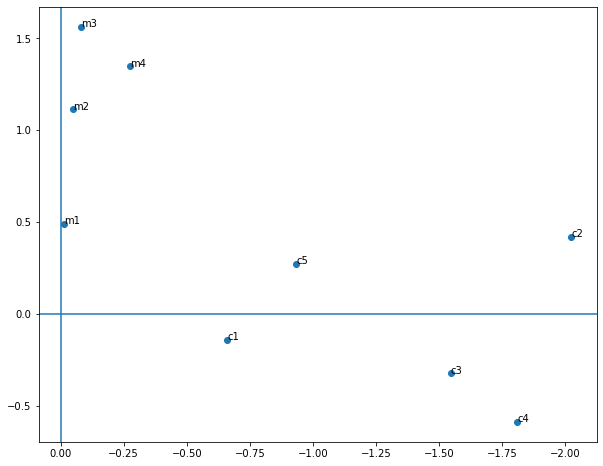

In [14]:
#Visualize documents and print coordinates
d = np.dot(Vk_t,Sk)#calculate coordinates
print(d)
import matplotlib.pyplot as plt

# get a figure handle
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(d[0:,0],d[0:,1])#use scatter to plot
w = ax.invert_xaxis()
plt.axhline(y=0)
plt.axvline(x=0)
n = np.arange(0,len(d),1)
for i, ind in enumerate(n):#add number for each point
    ax.annotate(docName[ind], (d[i,0], d[i,1]))
plt.show()   


##### Expected
```CPP
[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]
```
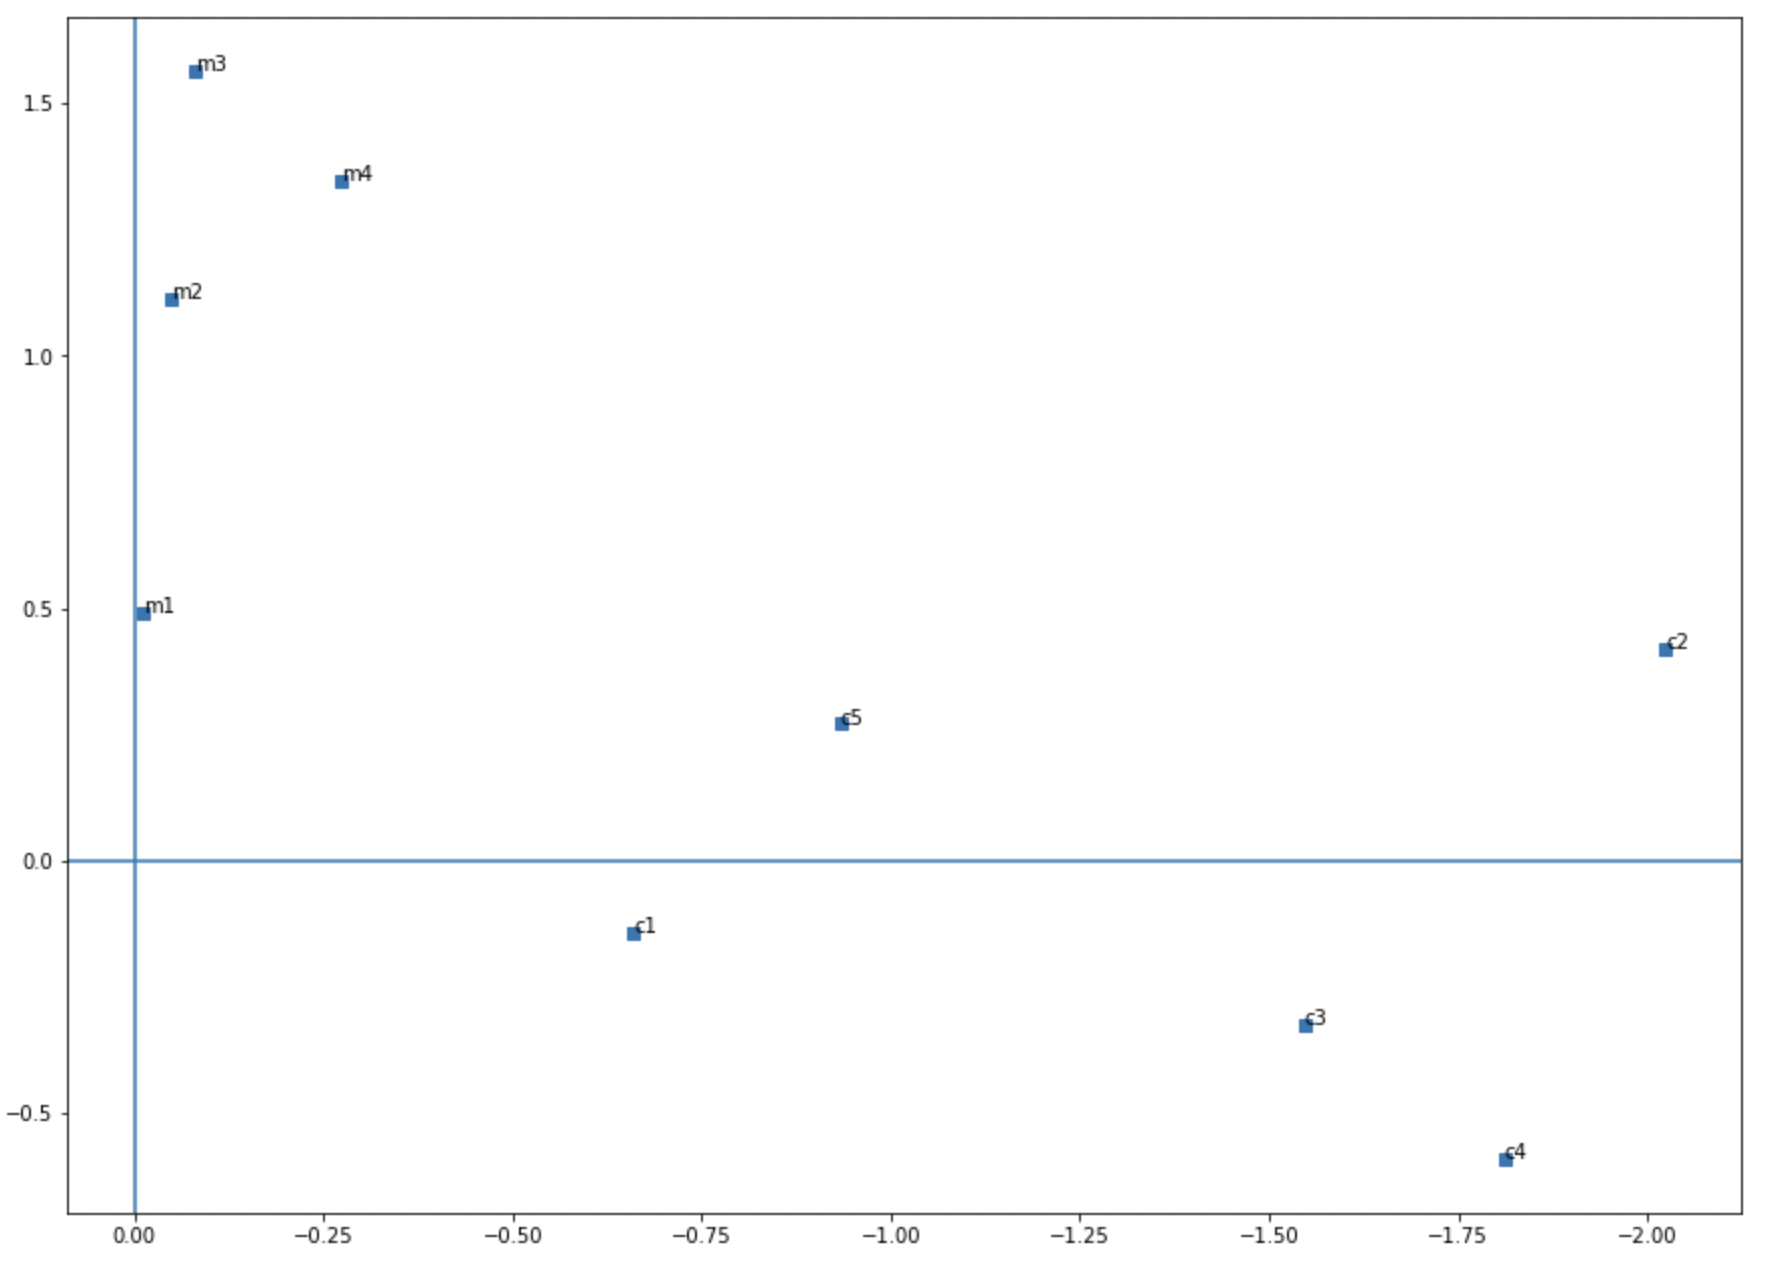

### Visualize terms in 2D space

In [15]:
word_to_ix

{'human': 0,
 'interface': 1,
 'computer': 2,
 'survey': 3,
 'user': 4,
 'system': 5,
 'response': 6,
 'time': 7,
 'EPS': 8,
 'trees': 9,
 'graph': 10,
 'minors': 11}

[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-0.68794764  0.69552995]
 [-1.34837689  0.14505553]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]


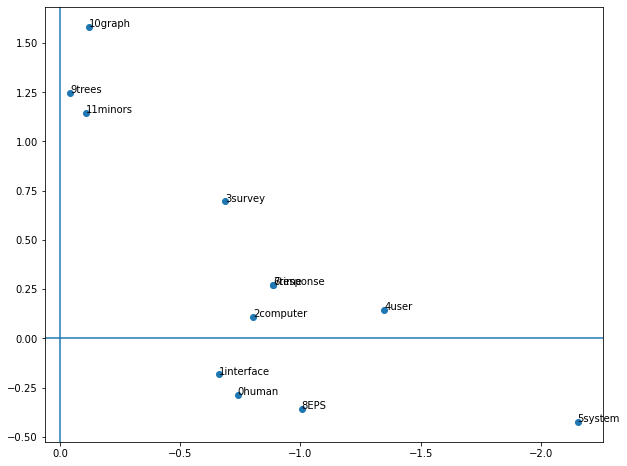

In [16]:
#Visualize terms and print coordinates
dd = np.dot(Uk,Sk)# calculate coordinates
print(dd)
import matplotlib.pyplot as plt

# get a figure handle
fig,ax = plt.subplots(figsize=(10,8))
ax.scatter(dd[0:,0],dd[0:,1])#use scatter to plot
w = ax.invert_xaxis()
plt.axhline(y=0)
plt.axvline(x=0)
n = np.arange(0,len(dd),1)
f = list(word_to_ix.keys())
for i, ind in enumerate(n):#add number for each point
    n = word_to_ix[f[ind]]
    ax.annotate(str(n)+f[ind], (dd[i,0], dd[i,1]))
plt.show()   


##### Expected
```CPP
[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-1.34837689  0.14505553]
 [-0.68794764  0.69552995]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]
```
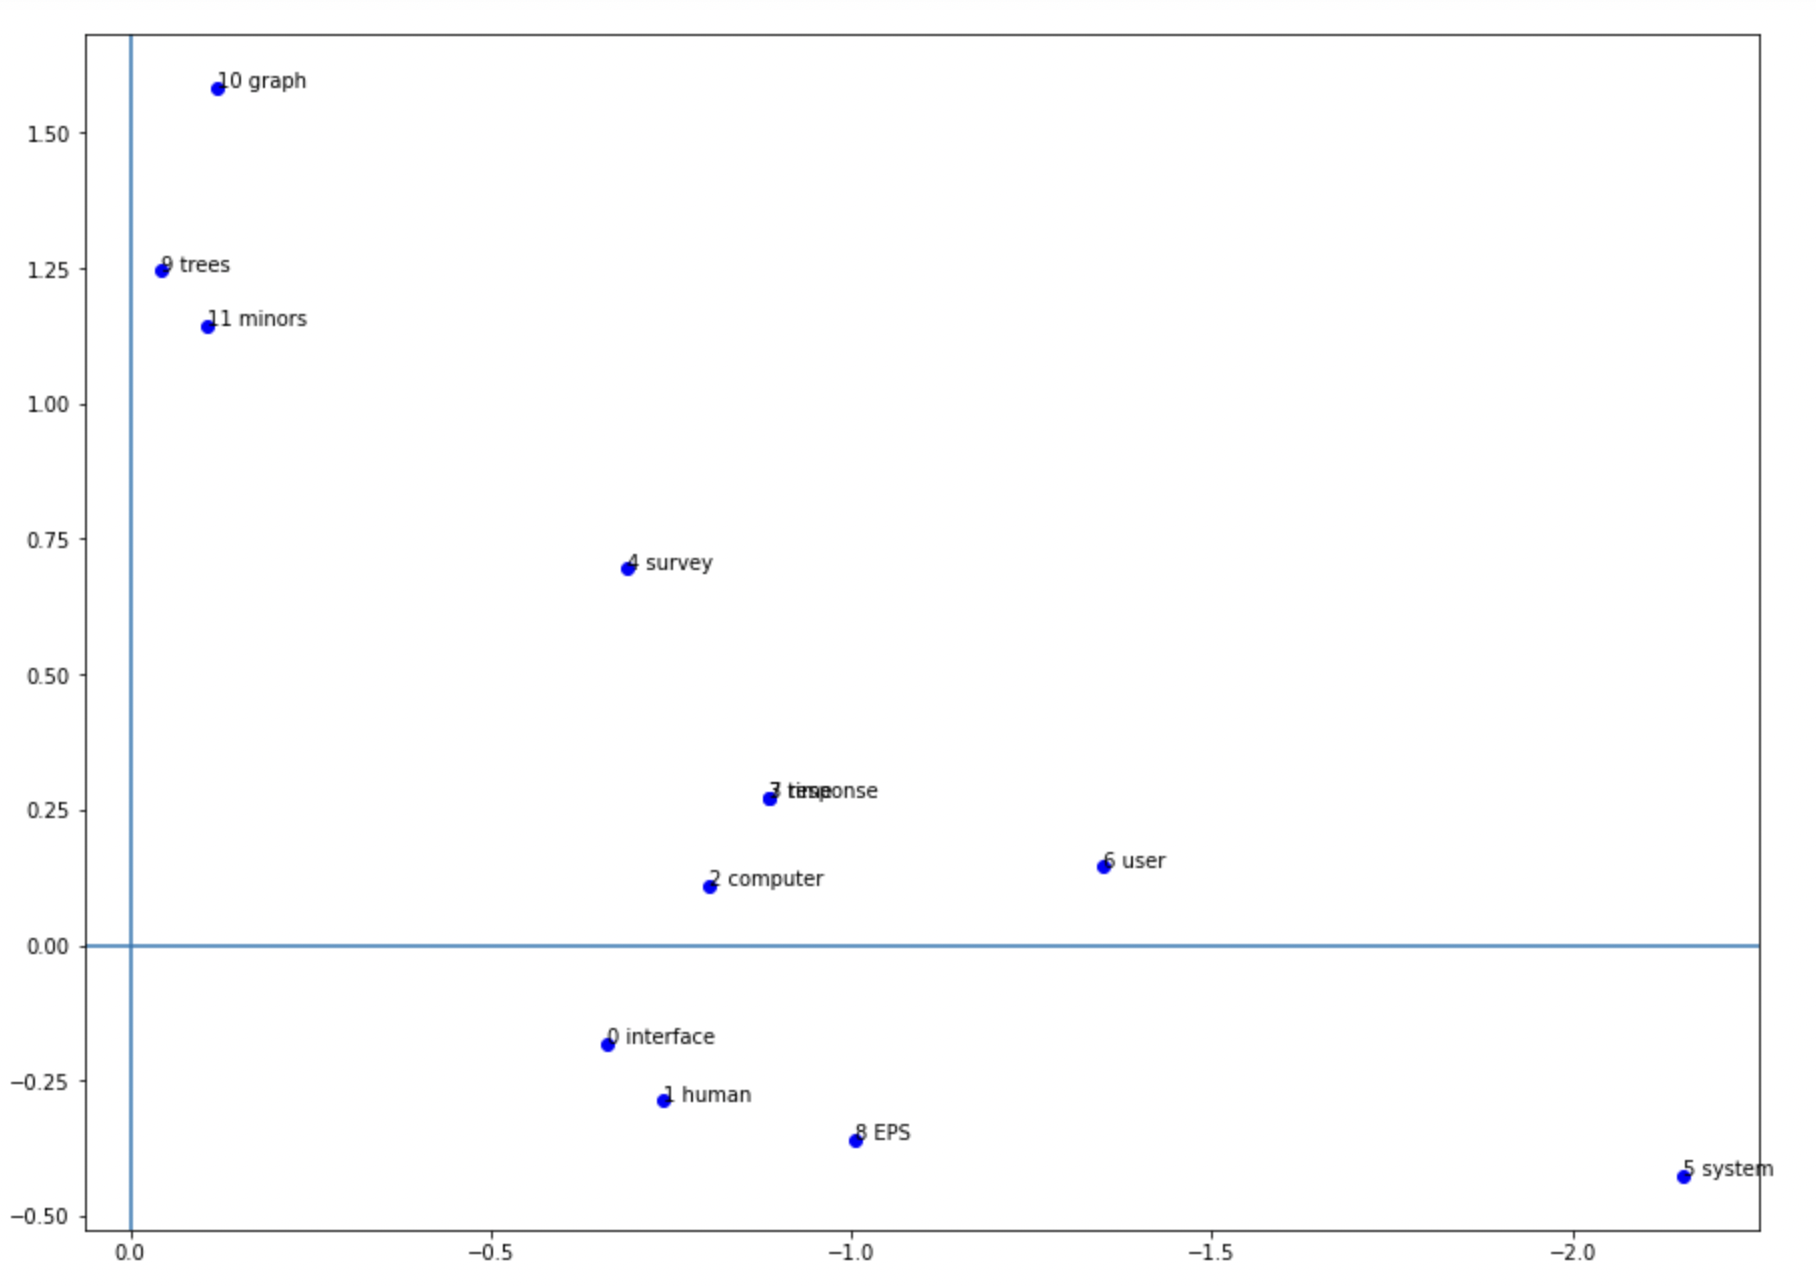

## <CENTER>Task-3 (10 Points)

### Find matching documents for given document

In [17]:
# Hint create query vector for input document. Calculate its cosine distance from other documents


def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
#     '''
#     Input:
#         s:query document.
#         Uk:Term matrix
#         Sk:singular value matrix
#         Vk_t:Document matrix
#         word_to_ix: {word, index} map
#         documents:list of document
#         min_score:min score beyond which documents are considerd matching
#     Output:
#         q_hat: coordinates of query vector
#         matches: list of tuples containing matching document and its score
#     '''
    matches = []
    eh = build_td_matrix([s],word_to_ix)
    q_hat = np.dot(eh.T,Uk)# calculate q_hat
    d = np.dot(Vk_t,Sk)
    column_number = np.size(d.T,1)
    for co in range(column_number):#loop each messgae column
        cos_sim = np.float64(np.dot(q_hat,d.T[:,co]) /( np.linalg.norm(d.T[:,co])* np.linalg.norm(q_hat)))#calculate cosine value
        if cos_sim > min_score:
            l = (documents[co],cos_sim)
            matches.append(l)
  
    return q_hat, matches

In [18]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[[-0.461821   -0.07002767]]
[('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('A survey of user opinion of computer system response time', 0.9374863669686585), ('The EPS user interface management system', 0.998445281334027), ('System and human system engineering testing of EPS', 0.9865886405556591), ('Relation of user-perceived response time to error measurement', 0.9075594362644324)]


##### Expected
```CPP
[-0.461821   -0.07002767]
[('The EPS user interface management system', 0.9984452813340272), ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('System and human system engineering testing of EPS', 0.9865886405556598), ('A survey of user opinion of computer system response time', 0.9374863669686595), ('Relation of user-perceived response time to error measurement', 0.9075594362644345)]
```

### Visual representation of query/document

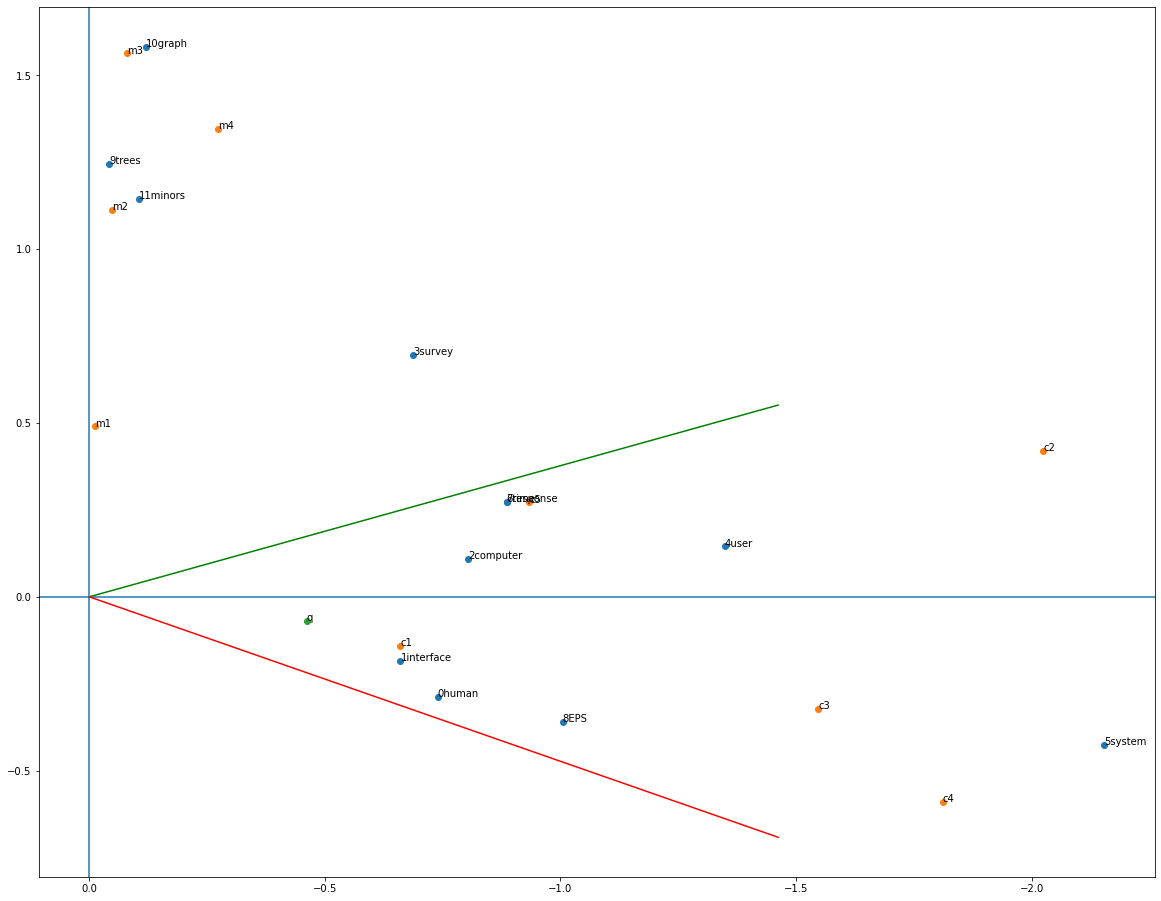

In [19]:
# Plot terms, documents and query documents along with lines representing its cosine angle 
fig,ax = plt.subplots(figsize=(20,16))


ax.scatter(dd[0:,0],dd[0:,1])#use scatter to plot
w = ax.invert_xaxis()
plt.axhline(y=0)
plt.axvline(x=0)
n = np.arange(0,len(dd),1)
f = list(word_to_ix.keys())
for i, ind in enumerate(n):#add number for each point
    n = word_to_ix[f[ind]]
    ax.annotate(str(n)+f[ind], (dd[i,0], dd[i,1]))

    
ax.scatter(d[0:,0],d[0:,1])#use scatter to plot
n1 = np.arange(0,len(d),1)
for i, ind in enumerate(n1):#add number for each point
    ax.annotate(docName[ind], (d[i,0], d[i,1]))

    
ax.scatter(q_hat[0:,0],q_hat[0:,1])#use scatter to plot q
ax.annotate('q', (q_hat[0,0], q_hat[0,1]))


plt.plot([0,-1 + q_hat[0,0]],[0, 1 * math.cos(.9) + q_hat[0,1]],color = 'g')#lines representing its cosine angle
plt.plot([0,-1 + q_hat[0,0]],[0, -1 * math.cos(.9) + q_hat[0,1]],color = 'r')#lines representing its cosine angle

    
plt.show()   


##### Expected

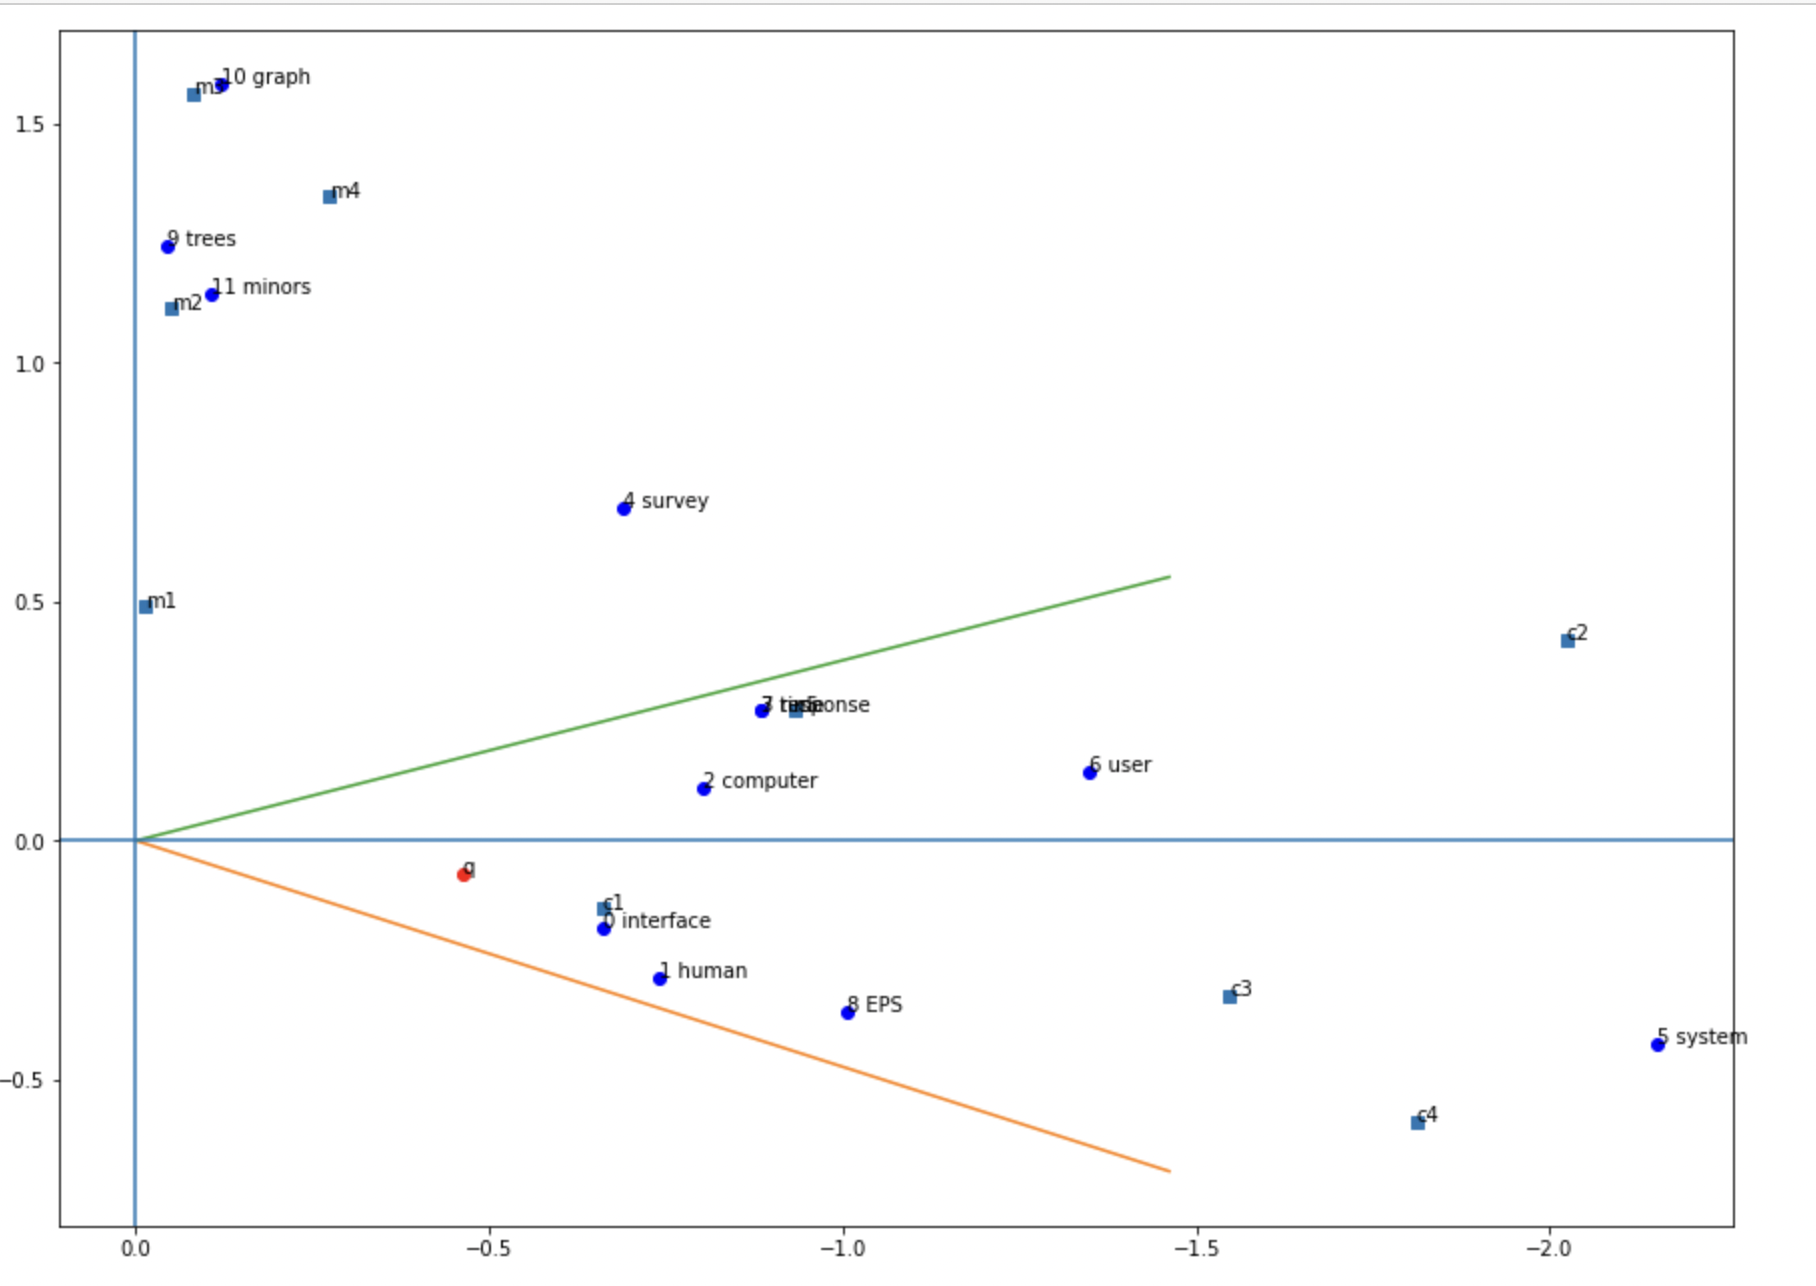


## **Theory questions: (5 points)**
- A) Give short description of Left-eigen vectors, right-eigen vectors and eigen-values matrix retured by Singular Value Decompostion of document-terms count matrix.

Left-eigen vectors, right-eigen vectors have orthonormal columns, and are the matrices of left and right singular vectors.Right-eigen vectors are the eigenvectors of the Gram (inner-product) matrix. Left-eigen vectors are the eigenvectors of the covariance matrix Eigen-values matrix is diagonal. Eigen-values matrix is the diagonal matrix of singular values. Singular value decomposition (SVD) is unique up to certain row, column and sign permutation and by convention the diagonal elements of eigen-values matrix are constructed to be all positive and ordered in decreasing magnitude. The matrice of Left-eigen vectors, the matrice of right-eigen vectors and eigen-values matrix must all be of full rank.The beauty of an SVD is that it allows a simple strategy for optimal approximate fit using smaller matrices. If the singular values in eigen-values matrix, are ordered by size, the first k largest may be kept and the remaining smaller ones set to zero. The product of the resulting matrices is a matrix X which is only approximately equal to X, and is of rank k. It can be shown that the new matrix X is the matrix of rank k, which is closest in the least squares sense to X. Since zeros were introduced into
eigen-values matrix, the representation can be simplified by deleting the zero rows and columns of eigen-values matrix, to obtain a new diagonal matrix of eigen-values matrix, and then deleting the corresponding columns of Left-eigen vectors and right-eigen vectors , to obtain Left-eigen vectors and right-eigen vectors  respectively. The result is a reduced model




- B) Visually represent the document "Graph and tree generation" in 2D space along with words and documents as given in previous question.

In [20]:
q_hatt, matchess = query("Graph and tree generation" , Uk, Sk, Vk_t, word_to_ix, documents, 0.9)

In [21]:
q_hatt

array([[-0.03613585,  0.62278523]])

In [22]:
matchess

[('The generation of random, binary, unordered trees', 0.9994893286320654),
 ('The intersection graph of paths in trees', 0.9999010903647539),
 ('Graph minors IV: Widths of trees and well-quasi-ordering',
  0.9999793491388692),
 ('Graph minors: A survey', 0.9898509606948506)]

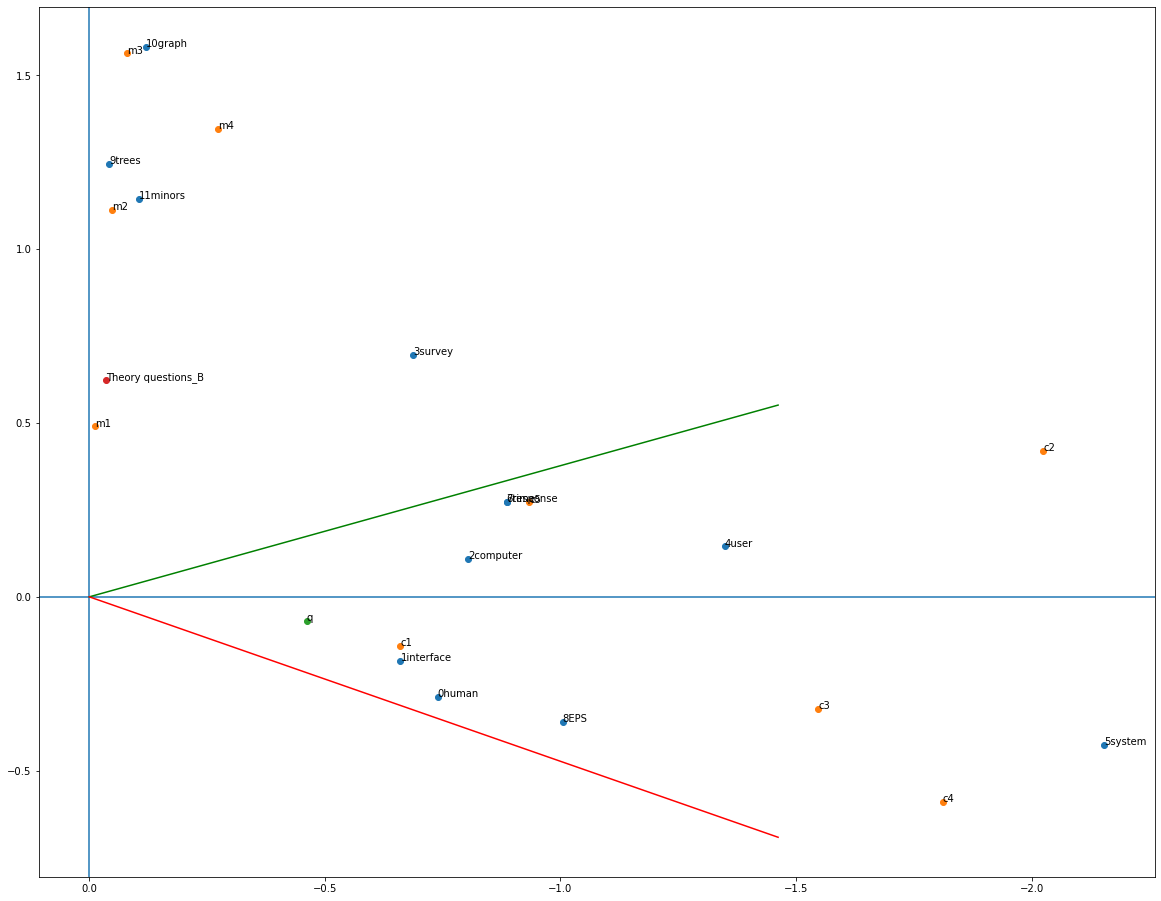

In [23]:
fig,ax = plt.subplots(figsize=(20,16))


ax.scatter(dd[0:,0],dd[0:,1])#use scatter to plot
w = ax.invert_xaxis()
plt.axhline(y=0)
plt.axvline(x=0)
n = np.arange(0,len(dd),1)
f = list(word_to_ix.keys())
for i, ind in enumerate(n):#add number for each point
    n = word_to_ix[f[ind]]
    ax.annotate(str(n)+f[ind], (dd[i,0], dd[i,1]))

    
ax.scatter(d[0:,0],d[0:,1])#use scatter to plot
n1 = np.arange(0,len(d),1)
for i, ind in enumerate(n1):#add number for each point
    ax.annotate(docName[ind], (d[i,0], d[i,1]))

    
ax.scatter(q_hat[0:,0],q_hat[0:,1])#use scatter to plot q
ax.annotate('q', (q_hat[0,0], q_hat[0,1]))

ax.scatter(q_hatt[0:,0],q_hatt[0:,1])#use scatter to plot  "Graph and tree generation" 
ax.annotate('Theory questions_B', (q_hatt[0,0], q_hatt[0,1]))

plt.plot([0,-1 + q_hat[0,0]],[0, 1 * math.cos(.9) + q_hat[0,1]],color = 'g')
plt.plot([0,-1 + q_hat[0,0]],[0, -1 * math.cos(.9) + q_hat[0,1]],color = 'r')

    
plt.show()   

# Q2. n-Gram Language Models

Your task is to train n-gram language models. [Ref SLP Chapter 3]

- Task 1: You will train unigram, bigram, and trigram models on given training files. Then you will score on given test files for unigram, bigram, and trigram. you will generate sentences from the trained model and compute perplexity.
- Task 2: You will create training data for n > 3. and Repeat the above task from training model.
<h6>Part-A = (55 Points) </h6>

In [2]:
'''
Your imports go here
You are encouraged to implement your own functions and not use from library.
'''
import sys
from collections import Counter
import numpy as np

In [7]:
# constants to define pseudo-word tokens
# access via UNK, for instance
# for this assignemnt we will follow <s> tag for beginning of sentence and
# </s> for end of senetence as suggested in SLP Book. Check sample training files for reference.
UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

We need to initialise global variables for model

In [8]:

"""Initializes Parameters:
  n_gram (int): the n-gram order.
  is_laplace_smoothing (bool): whether or not to use Laplace smoothing
  threshold: words with frequency  below threshold will be converted to token
"""
# Initializing different object attributes
n_gram = 1 
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = {}
threshold = 1
file_n = 2 #this value represent upload file which is binary training 


### Implement training function (10 points)

In [9]:
def make_ngrams(tokens: list, n: int) -> list:
    """
    Creates n-grams for the given token sequence.
    Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create
    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    n_grams = []
    start_ind = 0# record each message's final SENT_BEGIN position
    end_ind = 0#record each message's final SENT_END position
    counted_end = 0# Number of occurrences of SENT_END
    count_SENT_BEGIN = 0 #Number of occurrences of SENT_BEGIN
    if n == 1:
        for s in range(len(tokens)):
            temp_tuple = tuple([tokens[s]])
            n_grams.append(temp_tuple)
    else:
        for s in range(len(tokens)):
            if tokens[s] == SENT_BEGIN:
                start_ind = s
                count_SENT_BEGIN += 1# this value is used to find this message begin(first SENT_BEGIN )
            elif tokens[s] == SENT_END:
                end_ind = s
                counted_end += 1#this value is used to find this message end (final SENT_END)
            if counted_end == n-1:
                for i in range(start_ind-(count_SENT_BEGIN-1)+(n-1),end_ind+1):#set message length
                    n_grams.append(tuple([tokens[i-p] for p in reversed(range(n))]))
                counted_end = 0 #repeat 0 for each message
                count_SENT_BEGIN = 0#repeat 0 for each message
            
                
        #n_grams = [(tuple([tokens[i-p-1] for p in reversed(range(n-1))]), tokens[i]) for i in range(n-1, len(tokens)-)]
    ## Your code here 
    return n_grams

In [10]:
def train(training_file_path,n: int,file_n:int):
#     """Trains the language model on the given data. Input file that
#     has tokens that are white-space separated, has one sentence per line, and
#     that the sentences begin with <s> and end with </s>
#     Parameters:
#       training_file_path (str): the location of the training data to read

#     Returns:
#     N Gram Counts, Vocab, N Minus 1 Gram Counts
#     """
    with open(training_file_path, 'r') as fh:
        content = fh.read().split("\n")  # Read and split data to get list of words
    if n > file_n:#if the number of gram is bigger than the gram number of trainning file
        for m in range(len(content)):
            content[m] = '<s> '*(n-file_n)+content[m]+' </s>'*(n-file_n)
    con_t = []
    for co in content:#and split data to get list of words
        con_t += co.split()
    content = con_t
    
    # Get the count of each word
    count_each_word = {}
    for i in content:
        if i not in count_each_word.keys():
            count_each_word[i] = 1
        else:
            count_each_word[i] += 1
    # Replace the words with <UNK> if count is < threshold(=1)
    for key in count_each_word.keys():
        if count_each_word[key] < 2:
            suoying = content.index(key)
            content[suoying] = UNK
    # make use of make_n_grams function
    n_grams = make_ngrams(content, n)
    n_gram_counts = {}
    for k in n_grams:
        if k not in n_gram_counts:
            n_gram_counts[k] = 1
        else:
            n_gram_counts[k] += 1
    # Get the training data vocabulary
    vocab = list(set(content))
    # For n>1 grams compute n-1 gram counts to compute probability
    n_minus_1_gram_counts = {}
    if n > 1:
        for kk in n_gram_counts.keys():#use n_gram_counts tuple to set n-1 gram key
            if kk[:n-1] not in n_minus_1_gram_counts:
                n_minus_1_gram_counts[kk[:n-1]] = n_gram_counts[kk]
            else:
                n_minus_1_gram_counts[kk[:n-1]] += n_gram_counts[kk]
        return n_gram_counts, vocab, n_minus_1_gram_counts
    else:
        return n_gram_counts, vocab,len(content)# the number of all words in this content

Output your Trained Data Parameters:

In [11]:
training_file_path1 = "C:/Users/54364/Desktop/6120/HW3/train_data/berp-training_bi.txt"
n_gram_counts, vocab, n_minus_1_gram_counts = train(training_file_path1,n_gram,file_n)
print(n_gram_counts)
print(vocab)

{('<s>',): 6756, ("let's",): 236, ('start',): 438, ('over',): 414, ('</s>',): 6756, ('my',): 36, ('mother',): 2, ('is',): 359, ('coming',): 3, ('to',): 2153, ('visit',): 3, ('and',): 261, ("i'd",): 508, ('like',): 1221, ('take',): 28, ('<UNK>',): 478, ('dinner',): 362, ('new',): 4, ('query',): 3, ('now',): 49, ("i'm",): 246, ('interested',): 42, ('in',): 312, ('some',): 323, ('middle',): 17, ('eastern',): 15, ('food',): 992, ('oh',): 51, ('i',): 2264, ('have',): 594, ('breakfast',): 127, ('increase',): 2, ('the',): 937, ('walking',): 56, ('distance',): 165, ('can',): 381, ('go',): 390, ('fifteen',): 110, ('minutes',): 209, ('from',): 205, ('icsi',): 156, ('would',): 652, ('french',): 87, ('okay',): 152, ('back',): 23, ('normal',): 3, ('stuff',): 3, ('what',): 235, ('about',): 967, ('mexican',): 92, ('uh',): 431, ('how',): 171, ('american',): 129, ('or',): 129, ('european',): 20, ('prefer',): 16, ('german',): 62, ('preferably',): 5, ('less',): 154, ('than',): 311, ('ten',): 271, ('dolla

### Scoring function (points 5):
Implement Score function that will take input sentence and output probability of given string representing a single sentence.

In [12]:
import math

In [23]:
def score(sentence,n,vocab):
    """Calculates the probability score for a given string representing a single sentence.
    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    # Split the input sentence and replace out of vocabulary tokens with <UNK> 
    sentence = sentence.split()
    for word in range(len(sentence)):
        if sentence[word] not in vocab:
            sentence[word] = UNK
        
    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    log_probability = 0
    test_grams = make_ngrams(sentence, n)
    if n == 1:
        for gram in test_grams:
            if gram in n_gram_counts.keys():
                log_probability += math.log((n_gram_counts[gram]+1)/(n_minus_1_gram_counts+len(vocab)))#use p(wn/wn-1) with laplace smooth
            else:
                log_probability += math.log((1)/(n_minus_1_gram_counts+len(vocab)))                                    
    elif n >= 2:
        for gram in test_grams:
            if gram in n_gram_counts.keys() and gram[:n-1] in n_minus_1_gram_counts.keys():
                log_probability += math.log((n_gram_counts[gram]+1)/(n_minus_1_gram_counts[gram[:n-1]]+len(vocab)))#use p(wn/wn-1) with laplace smooth
            elif gram not in n_gram_counts.keys() and gram[:n-1] in n_minus_1_gram_counts.keys():
                log_probability += math.log((1)/(n_minus_1_gram_counts[gram[:n-1]]+len(vocab)))
#             elif gram in n_2_gram_counts.keys() and gram[:n-1] not in n_2_minus_1_gram_counts.keys():
#                 log_probability += math.log((n_2_gram_counts[gram]+1)/(len(vocab_2)))            
#     elif n == 3:
#         for gram in test_grams:
#             if gram in n_3_gram_counts.keys() and gram[:n-1] in n_3_minus_1_gram_counts.keys():
#                 log_probability += math.log((n_3_gram_counts[gram]+1)/(n_3_minus_1_gram_counts[gram[:n-1]]+len(vocab_3)))
#             elif gram not in n_3_gram_counts.keys() and gram[:n-1] in n_3_minus_1_gram_counts.keys():
#                 log_probability += math.log((1)/(n_3_minus_1_gram_counts[gram[:n-1]]+len(vocab_3)))
#             elif gram in n_3_gram_counts.keys() and gram[:n-1] not in n_3_minus_1_gram_counts.keys():
#                 log_probability += math.log((n_3_gram_counts[gram]+1)/(len(vocab_3)))
                                            
            
    probablity =  math.exp(log_probability)    
            
    
    return probablity

In [24]:
with open('hw2-test_uni.txt', 'r') as fh:
    test_content = fh.read().split("\n")
num_sentences_1 = len(test_content)
ten_sentences_1 = test_content
print("# of test sentences: ", num_sentences_1)
probablities = []

# of test sentences:  100


In [25]:
# print probabilities/score of sentences in test content
for sentence in test_content:
    probablities.append(score(sentence,n_gram,vocab))
probablities = np.array(probablities)
mean = np.mean(probablities)
std_dev = np.std(probablities)

In [26]:
mean

2.5598857149408206e-06

In [27]:
probablities

array([3.47192020e-10, 2.12002772e-09, 4.94407988e-20, 1.75729277e-17,
       8.08122367e-23, 5.31724359e-18, 2.42912194e-15, 1.00750711e-27,
       5.72535738e-25, 1.14326314e-04, 8.69889855e-11, 1.37548938e-14,
       6.98956679e-18, 6.51671771e-08, 2.47259497e-12, 9.32149115e-08,
       2.72091854e-05, 1.04850724e-07, 1.79396651e-20, 3.28791860e-24,
       6.33530269e-42, 9.17361636e-38, 3.58572123e-27, 1.80906011e-18,
       2.91698909e-22, 3.07159369e-13, 1.11493048e-08, 4.01820289e-11,
       9.82152835e-26, 5.17222576e-17, 3.02389368e-15, 1.44978834e-21,
       2.31357675e-23, 1.96492687e-15, 1.55162395e-21, 1.19588628e-24,
       1.74608922e-14, 6.06081056e-16, 7.11172209e-21, 1.17326159e-13,
       1.95768606e-17, 3.30193958e-19, 9.25083559e-18, 1.24542842e-20,
       6.54363196e-20, 5.98730750e-23, 5.75335561e-11, 1.48492478e-10,
       1.93512170e-22, 2.98418568e-22, 2.17513370e-21, 2.18009835e-20,
       1.03221747e-09, 3.10413226e-09, 3.10413226e-09, 1.11266148e-15,
      

### Sentence generation (10 points)
Generate sentence from the above trained model
- To generate next word from a set of probable n-grams and their probabilities check below tutorial:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [42]:
def generate_sentence(n):
    """Generates a single sentence from a trained language model using the Shannon technique.
      
    Returns:
      str: the generated sentence
    """
    # Start with <s> and randomly generate words until we encounter sentence end
    # Append sentence begin markers for n>2
    # Keep track of previous word for stop condition
    if n > 1:
        sentence = ["<s>"]*(n-1)#set <s>
        prev_word = sentence[-1]
        k = 0
        while prev_word != "</s>":
            # Construct the (n-1) gram so far
            this_time_n_1_gram = tuple(sentence[k:k+n-1])
        # Get the counts of all available choices based on n-1 gram
            if n > 1:
                di = n_minus_1_gram_counts[this_time_n_1_gram]
                shannon_token = []
                shannon_prob = []
                for aad in n_gram_counts.keys():
                    if aad[:n-1] == this_time_n_1_gram:
                        shannon_token.append(aad[n-1])#single word from n-gram_count
                        shannon_prob.append(n_gram_counts[aad]/di)#words' probability
                selected_token = np.random.choice(shannon_token, 1, p=shannon_prob)#select 1
                while selected_token[0] == "<s>":
                    selected_token = np.random.choice(shannon_token, 1, p=shannon_prob)
                sentence.append(selected_token[0])#sentence append
#             elif n == 2:
#                 di = n_2_minus_1_gram_counts[this_time_n_1_gram]
#                 shannon_token = []
#                 shannon_prob = []
#                 for aad in n_2_gram_counts.keys():
#                     if aad[:1] == this_time_n_1_gram:
#                         shannon_token.append(aad[1])
#                         shannon_prob.append(n_2_gram_counts[aad]/di)
#                 selected_token = np.random.choice(shannon_token, 1, p=shannon_prob)
#                 while selected_token[0] == "<s>":
#                     selected_token = np.random.choice(shannon_token, 1, p=shannon_prob)
#                 sentence.append(selected_token[0])
            prev_word = sentence[-1]#updata 
            k += 1
                    
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
    else:
        sentence = ["<s>"]
        k = 0
        prev_word = sentence[-1]
        shannon_token = []
        shannon_prob = []
        for token in n_gram_counts.keys():
            shannon_token.append(token[0])
            shannon_prob.append(n_gram_counts[token]/n_minus_1_gram_counts)#words' prob
            
      # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
        while prev_word != "</s>":
            selected_token = np.random.choice(shannon_token, 1, p=shannon_prob)
            while selected_token[0] == "<s>":
                selected_token = np.random.choice(shannon_token, 1, p=shannon_prob)
            sentence.append(selected_token[0])
            prev_word = sentence[-1]
            k += 1
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word

    # Append sentence end markers for n>2
    
    return ' '.join(sentence)

In [43]:
def generate(n,number_gram):
    """Generates n sentences from a trained language model using the Shannon technique.
    Parameters:
      n (int): the number of sentences to generate
      
    Returns:
      list: a list containing strings, one per generated sentence
    """
    sentences = []
    for nu in range(n):
        sentences.append(generate_sentence(number_gram))
    
    # Generate sentences one by one and store
    return sentences

In [50]:
sentences = generate(50,n_gram)
print("Sentences:")
for sentence in sentences:
    print(sentence)

Sentences:
<s> no more information about le cheval </s>
<s> what do you give me information about ay-caramba berkeley </s>
<s> um do you want to eat polish restaurants to spend any distance of italian food is spats open all kinds of restaurant with a middle eastern food </s>
<s> since it's a half an indian food </s>
<s> i want to spend five minute drive of metropole </s>
<s> it could sit outside </s>
<s> i would like to eat on sunday only uh how can you know the restaurant should be less than ten dollars </s>
<s> the restaurant with something more than ten dollars </s>
<s> can you give me international house </s>
<s> i'm looking for a late night or fifteen dollars </s>
<s> show me more about the international house is not more information on sunday </s>
<s> <UNK> </s>
<s> okay give me information about a uh japanese food </s>
<s> start over again </s>
<s> it's okay let's start over </s>
<s> let's try </s>
<s> i want to have more than ten minutes </s>
<s> lunch </s>
<s> tell me more tha

### Evaluate model perplexity (5 points)
Measures the perplexity for the test sequence with your trained model. 
you may assume that this sequence may consist of many sentences "glued together"

The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words.


In [51]:
# Since this sequence will cross many sentence boundaries, we need to include 
# the begin- and end-sentence markers <s> and </s> in the probability computation. 
# We also need to include the end-of-sentence marker </s> 
# but not the beginning-of-sentence marker <s>) in the total count of word tokens N

def perplexity(test_sequence,number_gram,vocab_gram):
    """.
    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of

    Returns:
      float: the perplexity of the given sequence
    """ 

    # Replace out of vocab words with <UNK>, already done in score function
    #test_sequence = [token if token in vocab else UNK for token in test_sequence.split()]


    # Remove sentence begin markers from data for computing N
    k = 0
    for tt in test_sequence.split():
        if tt == "<s>":
            k += 1
    N = len(test_sequence.split())- k# k is the number of <s>
            

    # Get the probability for the sequence
    probability = score(test_sequence,number_gram,vocab_gram)
    perplexity = math.pow(1/probability,1/N)
    return perplexity

In [52]:
print(perplexity(" ".join(sentences[0:10]),n_gram,vocab))

51.103004181029476


### **Explore and explain: (5 points)**
* Experiment n_gram model for n = [1,2,3..7] of your choice. Explain the best choice of n that generates more meaninful sentences.
From the above results, the perplexity becomes smaller as n becomes larger.  When n is larger，more constrained information about the next word occurrence, greater discriminative power, but more sparse.And the total number of n-grams is also higher. Smaller n has more occurrences in the training corpus, more reliable statistical results, higher reliability , but less constraint information

# Q3. Classification using LSTM - using Tensorflow (30 Points)
In this part, we will be building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.<br>

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time to tweak your hyperparameters.
- Without a GPU, You might have to wait longer to experiment.

### Library Imports

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



### Visualizing data distribution (1 Point)


In [2]:
from google.colab  import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
## Reading the data and removing columns that are not important. 
dataset = pd.read_csv("/content/drive/MyDrive/movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [4]:
#  ######################################################   
#  print head of data frame with help of head function # 
#  ######################################################
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


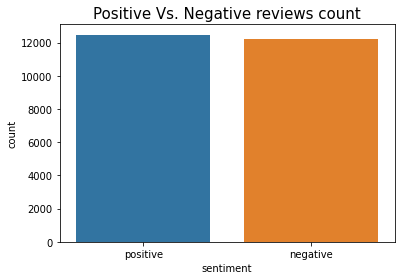

In [5]:
 ####################################################### 
 # plot Positive Vs. Negative reviews count            # 
 #######################################################

sns.countplot(x = "sentiment",data = dataset)

plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()



### Cleaning the Reviews (2 Points)

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [7]:
 #############################################################################################  
 # Clean all the reviews in the dataset using the clean_text function provided above         # 
 ############################################################################################# 
for i in range(len(dataset['review'])):
    dataset['review'][i] = clean_text(dataset['review'][i])



In [8]:
 #####################################################################
 # print head of the "CLEANED" data frame with help of head function # 
 #####################################################################
dataset.head()


,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,positive
1,wonderful little production br br filming tech...,positive
2,thought wonderful way spend time hot summer we...,positive
3,petter matteis love time money visually stunni...,positive
4,probably alltime favorite movie story selfless...,positive


### Splitting the dataset and Encoding Labels (2 Points)

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [9]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################
from sklearn.model_selection import train_test_split#use sklearn's train_test_split to randomly select train and test data

training, validation = train_test_split(dataset, test_size=0.2, random_state=42)#80% of this data become train data and 20% of this data become test data,set random seed 42


In [10]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(training['sentiment'])

train_labels = le.transform(training['sentiment'])
validation_labels = le.transform(validation['sentiment'])

### Pre-Processing The Text (5 Points)
 

In [11]:
# You can use the modules given below
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

###############################################################################  
# Fit your tokenizer on the training reviews                                  #
##t.word_index#############################################################################
t  = Tokenizer()
t.fit_on_texts(training['review'])


#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                  #
#################################################################################################

word_index = t.word_index

vocabulary = len(t.word_index)+1 #the number of vocabulary,add 1


#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
# HINT : convert training and validation reviews into sequences                                 #
#################################################################################################
training_sequences = t.texts_to_sequences(training['review'])
validation_sequences = t.texts_to_sequences(validation['review'])


#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
# set maxlen = 200                                                                              #
#################################################################################################
training_sequences = pad_sequences(training_sequences,maxlen = 200)
validation_sequences = pad_sequences(validation_sequences,maxlen = 200)
# maxlen which is the maximum length of one review we will use for our training

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : 99735


In [12]:
training_sequences

array([[    0,     0,     0, ...,   860,  2574,  3873],
       [    0,     0,     0, ...,   447,   391,   215],
       [    0,     0,     0, ..., 34826,  1042,   100],
       ...,
       [    0,     0,     0, ...,    50,  1211,  6632],
       [ 3394,    29,   760, ...,  4330,  2570,   123],
       [    0,     0,     0, ...,   745,   142,    55]], dtype=int32)

### Using glove vectors for embedding (5 Points)

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.

To learn more about GloVe please read the following resource:
- https://nlp.stanford.edu/pubs/glove.pdf

In [13]:
glove_dictionary = {}
with open('/content/drive/MyDrive/glove.6B.200d.txt',encoding='utf-8') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [14]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

embedding_matrix = np.zeros((vocabulary, 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################
for key,index in word_index.items():
    if key in glove_dictionary.keys():# if key in glove
        embedding_matrix[index] = glove_dictionary.get(key)


In [15]:
embedding_matrix.shape

(99735, 200)

In [16]:
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [-0.39533  , -0.17097  ,  0.0020488, ...,  0.36135  ,  0.94448  ,
        -0.15177  ],
       [ 0.33201  ,  0.30195  , -0.88213  , ...,  0.075378 ,  0.39154  ,
         0.57609  ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ]])

Sample output : (99987, 200)

### Creating The Model (10)

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time.
- Without a GPU, You might have to wait longer to experiment.


Useful resources : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout <br>





In [17]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
from keras import regularizers

In [18]:
import tensorflow as tf

tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):

#   ''' 
#   Arguments:
#     embedding_matrix : a matrix with the corresponding embeddings
#     of all words.

#   Returns:
#     The LSTM model that you created.
#   '''
    model = tf.keras.Sequential()

  # TO DO: layer 1 : add embedding layer
  # The embedding layer maps the words to their embedding vectors from the embedding matrix
    model.add(tf.keras.layers.Embedding(len(embedding_matrix), 200, weights=[embedding_matrix], input_length=200, trainable=False))
    # transfer

  # TO DO: layer 2 : add Bidirectional LSTM Layer 
    model.add(tf.keras.layers.Bidirectional(LSTM(64)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(256, activation=tf.nn.relu))
    #model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(128, activation=tf.nn.relu))
    #model.add(tf.keras.layers.Dropout(0.5))
    #model.add(tf.keras.layers.Dense(8, activation=tf.nn.relu))
    #model.add(tf.keras.layers.Dropout(0.2))
    #model.add(tf.keras.layers.Dense(4, activation=tf.nn.relu))
    # model.add(tf.keras.layers.Dense(2, activation=tf.nn.relu))


  # TO DO Add more layers : you can add more dense layers and dropout
    model.add(tf.keras.layers.Dropout(0.5))
    
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # NOTE : You should be able to achieve an validation accuracy greater than 85%
  #        within 10 epochs

   
  # TO DO Final layer : add output layer and activation 


  # TO DO : use a loss function, optimizer as adam to compile 
  # and evaluate model on auc,precision,recall,accuracy
  # HINT : choose your loss function based on the task (binary classification)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=["AUC","Precision","Recall","accuracy"]) #["AUC","Precision","Recall","Accuracy"])
    return model

In [19]:
# NOTE : You should be able to achieve an validation accuracy greater than 85%
#        within 10 epochs

#################################################################
# Call the build_model function and initialize the model        #
#################################################################
model = build_model(embedding_matrix)
#######################################################################################################
# train and validate the model on the padded sequences of text which we have created initially        #
#######################################################################################################


In [20]:
history=model.fit(training_sequences, train_labels,
          batch_size=16,
           epochs=10,
           validation_data=[validation_sequences, validation_labels])

Epoch 1/10
1235/1235 [==============================] - 35s 19ms/step - loss: 0.4975 - auc: 0.8404 - precision: 0.7726 - recall: 0.7736 - accuracy: 0.7701 - val_loss: 0.4365 - val_auc: 0.9166 - val_precision: 0.8770 - val_recall: 0.7762 - val_accuracy: 0.8336
Epoch 2/10
1235/1235 [==============================] - 23s 19ms/step - loss: 0.3820 - auc: 0.9103 - precision: 0.8375 - recall: 0.8471 - accuracy: 0.8394 - val_loss: 0.3260 - val_auc: 0.9394 - val_precision: 0.8654 - val_recall: 0.8640 - val_accuracy: 0.8648
Epoch 3/10
1235/1235 [==============================] - 23s 19ms/step - loss: 0.3301 - auc: 0.9334 - precision: 0.8640 - recall: 0.8665 - accuracy: 0.8634 - val_loss: 0.3045 - val_auc: 0.9455 - val_precision: 0.8927 - val_recall: 0.8284 - val_accuracy: 0.8644
Epoch 4/10
1235/1235 [==============================] - 23s 19ms/step - loss: 0.2962 - auc: 0.9468 - precision: 0.8797 - recall: 0.8761 - accuracy: 0.8766 - val_loss: 0.2981 - val_auc: 0.9496 - val_precision: 0.8543 - va

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          19947000  
                                                                 
 bidirectional (Bidirectiona  (None, 128)              135680    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

### Plotting Accuracy and Losses (5 Points)
 




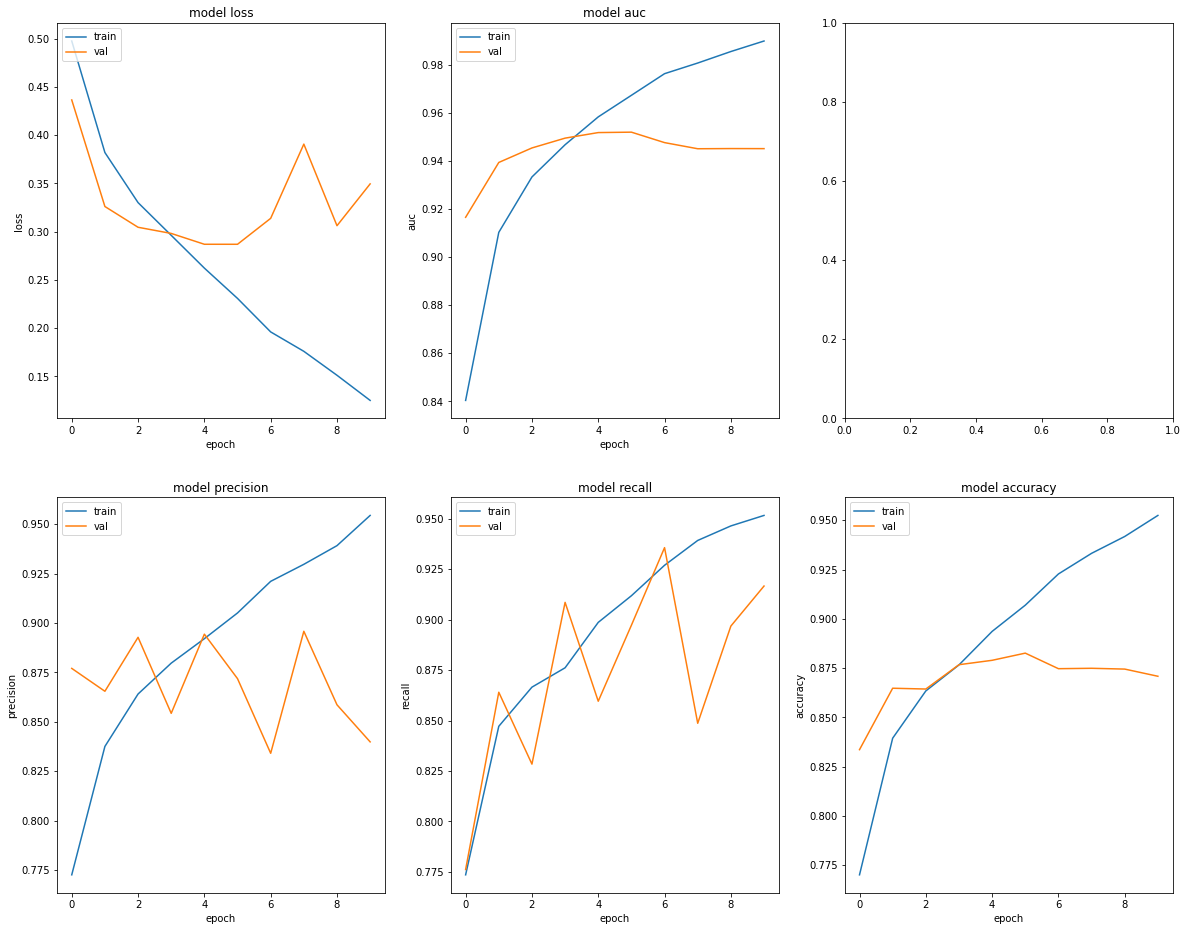

In [22]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################

# plot train loss vs val loss, train auc vs val auc, train recall vs val recall, train precision vs val precision and train accuracy vs val accuracy and comment your observations
from matplotlib import pyplot as plt
#fig,ax = plt.subplots(figsize=(10,8))
fig, axs = plt.subplots(2, 3,figsize=(20,16))

axs[0,0].plot(history.history['loss'])
axs[0,0].plot(history.history['val_loss'])
axs[0,0].set_title('model loss')
axs[0,0].set_ylabel('loss')
axs[0,0].set_xlabel('epoch')
axs[0,0].legend(['train', 'val'], loc='upper left')

axs[0,1].plot(history.history['auc'])
axs[0,1].plot(history.history['val_auc'])
axs[0,1].set_title('model auc')
axs[0,1].set_ylabel('auc')
axs[0,1].set_xlabel('epoch')
axs[0,1].legend(['train', 'val'], loc='upper left')

axs[1,0].plot(history.history['precision'])
axs[1,0].plot(history.history['val_precision'])
axs[1,0].set_title('model precision')
axs[1,0].set_ylabel('precision')
axs[1,0].set_xlabel('epoch')
axs[1,0].legend(['train', 'val'], loc='upper left')

axs[1,1].plot(history.history['recall'])
axs[1,1].plot(history.history['val_recall'])
axs[1,1].set_title('model recall')
axs[1,1].set_ylabel('recall')
axs[1,1].set_xlabel('epoch')
axs[1,1].legend(['train', 'val'], loc='upper left')

axs[1,2].plot(history.history['accuracy'])
axs[1,2].plot(history.history['val_accuracy'])
axs[1,2].set_title('model accuracy')
axs[1,2].set_ylabel('accuracy')
axs[1,2].set_xlabel('epoch')
axs[1,2].legend(['train', 'val'], loc='upper left')

plt.show()

In [23]:
# You will need to include the pickled model along with the other submission files
# The saved model will be used to verify your lstm's predictions on hidden reviews

##################################################################################
# Save your trained model as a pickle file named "lstm_classifier"               #
# You will be using this saved model to make predictions in the next module      #
##################################################################################

import pickle 
pickle.dump(model, open('lstm_classifier', 'wb'))

INFO:tensorflow:Assets written to: ram://9eba2132-3e0e-420c-85b1-d02266b0d4ae/assets


INFO:tensorflow:Assets written to: ram://9eba2132-3e0e-420c-85b1-d02266b0d4ae/assets


### Prediction (5 Points)

In [24]:
######################################################################
# Load your saved model                                              #
# Use the saved model to make predictions                            #
######################################################################

saved_model = pickle.load(open('lstm_classifier', 'rb'))

In [27]:
# use the saved model to predict the reviews
def predict_review(review):
  # '''
  # Arguments:
  #   review : A single review for which you want to predict the sentiment for.
  #            example: "This movie was amazing! I would defenitely watch it again."

  # Returns:
  #   The predicted sentiment for the review : either 1 or 0
  # '''

 ############################################################################# 
 # Predict the sentiment for the given review using the model                #
 # that you trained and return the sentiment                                 #
 #                                                                           #
 # HINT : Remember that the review needs to be "preprocessed" before you use #
 # it for prediction                                                         #
 #############################################################################
    predict_sequence = t.texts_to_sequences([clean_text(review)])
    predict_sequence = pad_sequences(predict_sequence,maxlen = 200)
    re = saved_model.predict(predict_sequence)
    if re >= 0.5:# set 1 or 0
        ans = 1
    else:
        ans = 0
    return ans





In [28]:
# Do not edit this cell

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:100]} -> {p}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0


### Expected Output:

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0 <br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0